In [1]:
# Add parent folder to path, so that we can import local dh_modelling Python module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dh_modelling.helpers import load_intermediate
from dh_modelling.evaluate import calculate_metrics

# Evaluating XGBoost model

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a recent architecture that is in many cases considered to be a good tool for building a model on tabular data, alongside with other gradient boosting methods (see e.g. [1], [2], [3], [4], [5], [6], [7], [8]). We will try to fit our model with XGBoost and see what level of error can we reach.

[Here](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f) is a thorough walk-through on hyperparameter tuning with XGBoost, we will use similar approach here.

The computations are done on a GPU, see [the documentation](https://xgboost.readthedocs.io/en/latest/gpu/index.html) on using GPU resources with XGBoost.


[1]: https://www.martinalarcon.org/2018-12-31-b-water-pumps/
[2]: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
[3]: https://www.quora.com/Does-supervised-deep-learning-work-better-than-XGBoost-on-tabular-data-when-you-have-loads-of-data
[4]: https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc
[5]: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
[6]: https://medium.com/kaggle-nyc/gradient-boosting-decision-trees-xgboost-vs-lightgbm-and-catboost-72df6979e0bb
[7]: https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d
[8]: https://www.slideshare.net/odsc/owen-zhangopen-sourcetoolsanddscompetitions1

In [3]:
df_train = load_intermediate(Path(module_path)/'data/processed/train.feather')
df_test  = load_intermediate(Path(module_path)/'data/processed/test.feather')

def _encode_x(func, col, max_val):
    return func(2 * np.pi * col/max_val)

def encode_sin_cos(data, col_name, max_val):
    col = data[col_name]
    data = data.drop(col_name, axis=1)
    data[col_name + '_sin'] = _encode_x(np.sin, col, max_val)
    data[col_name + '_cos'] = _encode_x(np.cos, col, max_val)
    return data

# df_train = df_train.drop('epoch_seconds', axis=1)
# df_test  = df_test.drop('epoch_seconds', axis=1)
# df_train = encode_sin_cos(df_train, 'day_of_year', 364)
# df_test  = encode_sin_cos(df_test,  'day_of_year', 364)

# df_train = encode_sin_cos(df_train, 'hour_of_day', 23)
# df_test  = encode_sin_cos(df_test,  'hour_of_day', 23)
# df_train = encode_sin_cos(df_train, 'day_of_week', 6)
# df_test  = encode_sin_cos(df_test,  'day_of_week', 6)

df_train

,dh_MWh,Ilman lämpötila (degC),hour_of_day,day_of_week,day_of_year,epoch_seconds,is_business_day
date_time,,,,,,,
2015-01-01 01:00:00+02:00,936.000,4.0,1,3,1,1420066800,0
2015-01-01 02:00:00+02:00,924.200,4.1,2,3,1,1420070400,0
2015-01-01 03:00:00+02:00,926.300,4.2,3,3,1,1420074000,0
2015-01-01 04:00:00+02:00,942.100,3.6,4,3,1,1420077600,0
2015-01-01 05:00:00+02:00,957.100,3.3,5,3,1,1420081200,0
...,...,...,...,...,...,...,...
2019-10-20 10:00:00+03:00,677.137,8.8,10,6,293,1571554800,0
2019-10-20 11:00:00+03:00,648.368,10.0,11,6,293,1571558400,0
2019-10-20 12:00:00+03:00,627.489,10.8,12,6,293,1571562000,0


In [4]:
X_train, y_train = df_train.drop("dh_MWh", axis=1), df_train[["dh_MWh"]]
X_test, y_test   = df_test.drop("dh_MWh", axis=1), df_test[["dh_MWh"]]

Some starting-point parameters that have been found with initial iteration

In [5]:
dx_train = xgb.DMatrix(data=X_train, label=y_train)
dx_test = xgb.DMatrix(data=X_test, label=y_test)

params = {
#    "objective":"reg:squaredlogerror",
#     'colsample_bytree': 0.3,
#     'learning_rate': 0.5,
#     'max_depth': 7,
#     'alpha': 10,
    'tree_method':'hist'
}

cv_results = xgb.cv(
    dtrain=dx_train,
    params=params,
    nfold=10,
    num_boost_round=200,
    early_stopping_rounds=10,
#     metrics="rmse",
    as_pandas=True,
    seed=123,
#     verbose_eval=True,
)

In [6]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,629.164862,0.428678,629.132165,3.812903
1,442.946048,0.293440,443.037231,2.606157
2,312.855914,0.194085,312.985657,1.897084
3,222.222531,0.156041,222.431641,1.352607
4,159.161691,0.162794,159.428203,1.038043
...,...,...,...,...
195,17.641254,0.112331,22.451463,0.333955
196,17.606957,0.110311,22.434491,0.342567
197,17.576207,0.118258,22.418770,0.342551
198,17.545555,0.123170,22.400987,0.338681


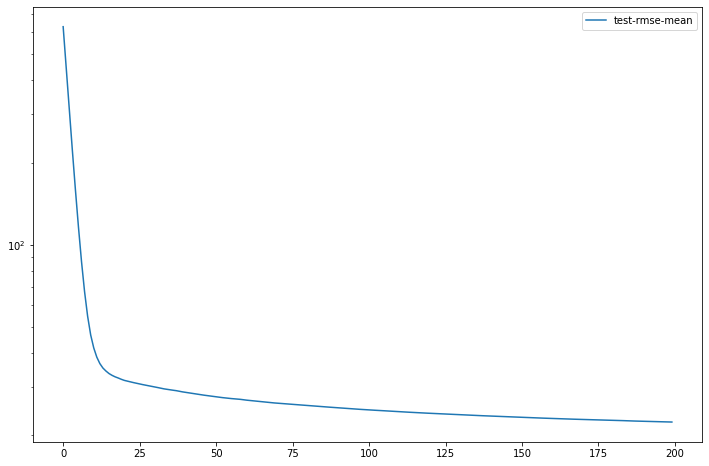

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
cv_results[['test-rmse-mean']].plot(ax=ax)
ax.set_yscale('log')
# ax.set_xscale('log')

In [8]:
xg_reg = xgb.train(params=params, dtrain=dx_train, num_boost_round=10)

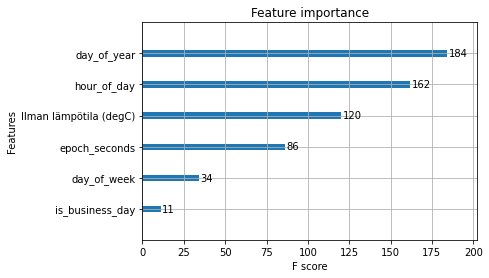

In [9]:
xgb.plot_importance(xg_reg)
plt.show()

As expected, ambient temperature is the most important feature, followed by date parameters,
most importantly hour-of-day

In [10]:
predicted = xg_reg.predict(dx_test)
actual = y_test.squeeze().to_numpy()

calculate_metrics(actual, predicted)

{'mean_absolute_error': 41.435479951569576,
 'mean_absolute_percentage_error': 0.060052684346592264,
 'root_mean_squared_error': 53.59658273460104}

## Plotting

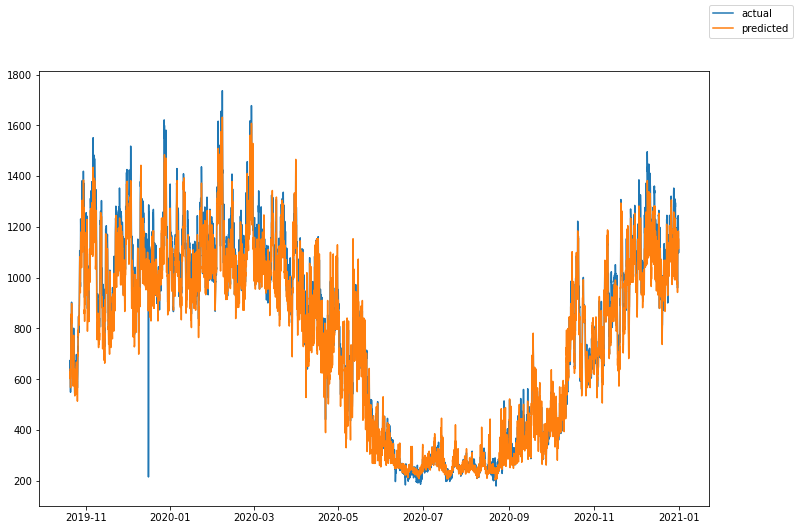

In [11]:
fig = plt.figure(figsize=(12,8))
# plt.plot(df_train.index, df_train['dh_MWh'], label='train')
plt.plot(df_test.index, actual, label='actual')
plt.plot(df_test.index, predicted, label='predicted')
fig.legend()

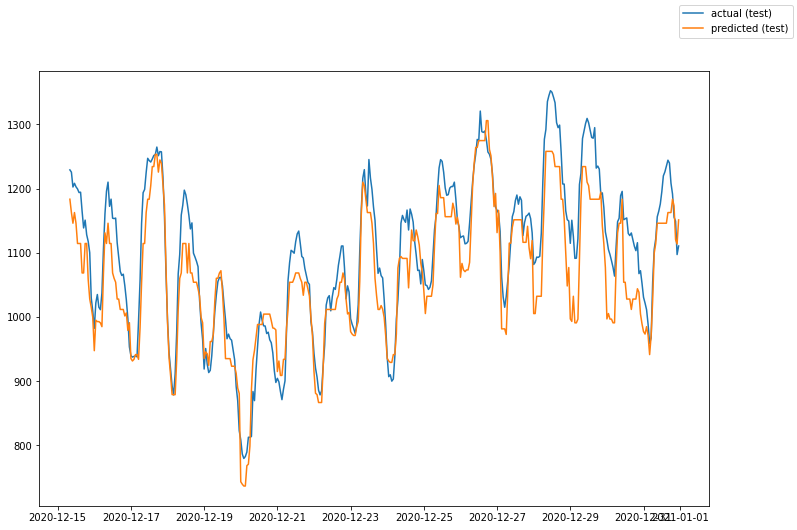

In [12]:
last_hours = 400

fig = plt.figure(figsize=(12,8))
plt.plot(df_test.index[-last_hours:], actual[-last_hours:], label='actual (test)')
plt.plot(df_test.index[-last_hours:], predicted[-last_hours:], label='predicted (test)')
fig.legend()

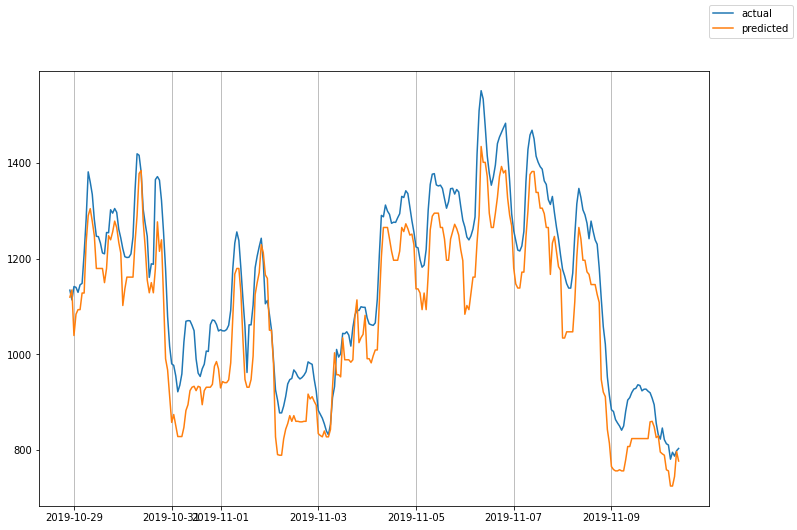

In [13]:
idx = slice(200,500)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_test.index[idx], actual[idx], label='actual')
ax.plot(df_test.index[idx], predicted[idx], label='predicted')
ax.xaxis.grid()
fig.legend()

It seems, that here we fail to follow the actual generation.

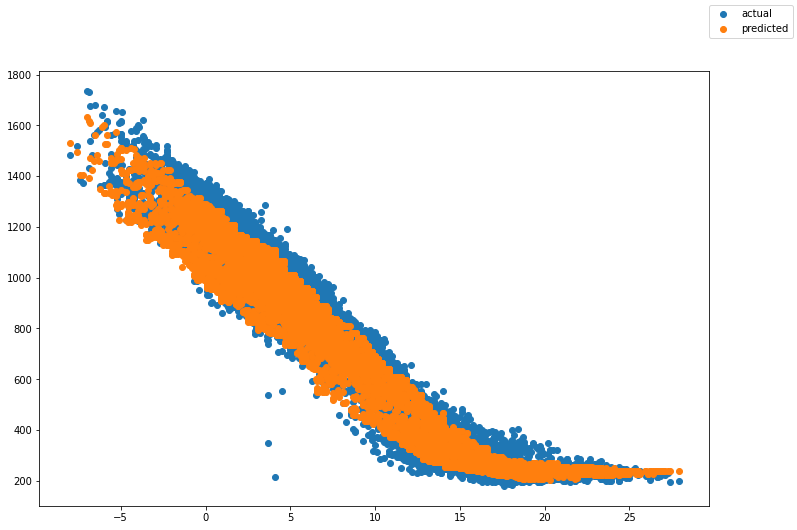

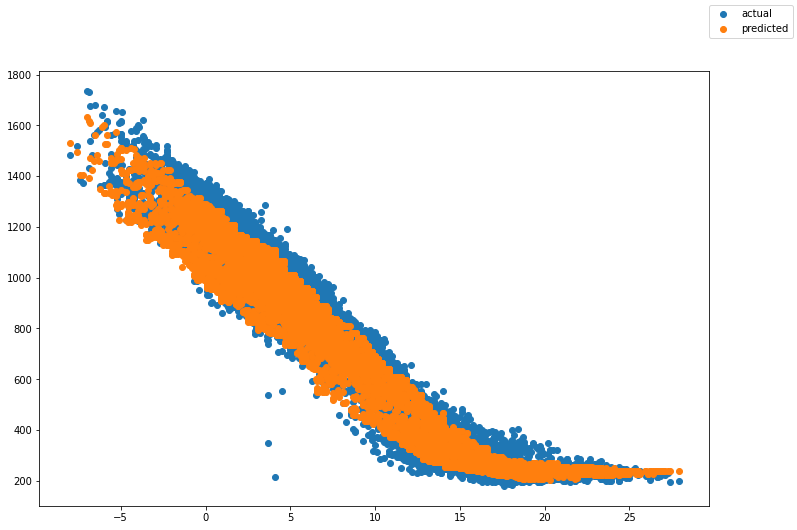

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x=X_test["Ilman lämpötila (degC)"], y=actual, label='actual')
ax.scatter(x=X_test["Ilman lämpötila (degC)"], y=predicted, label='predicted')
fig.legend()
fig

The predictions seem to underestimate variance, and generally, to underestimate generation.

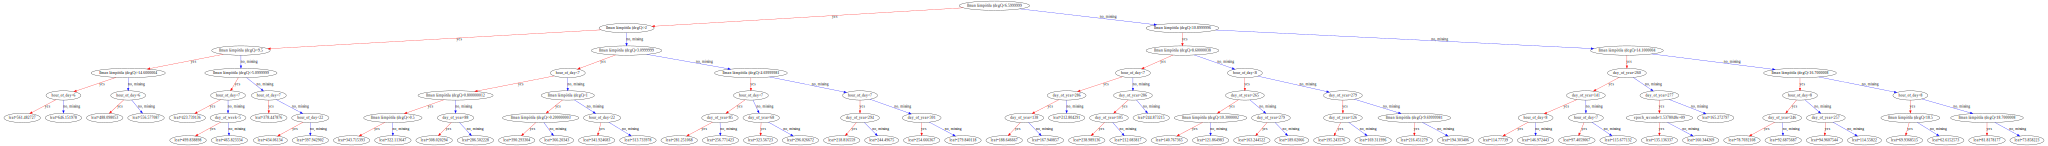

In [15]:
xgb.to_graphviz(xg_reg)

## When do errors occur?

<AxesSubplot:xlabel='hour_of_day', ylabel='error'>

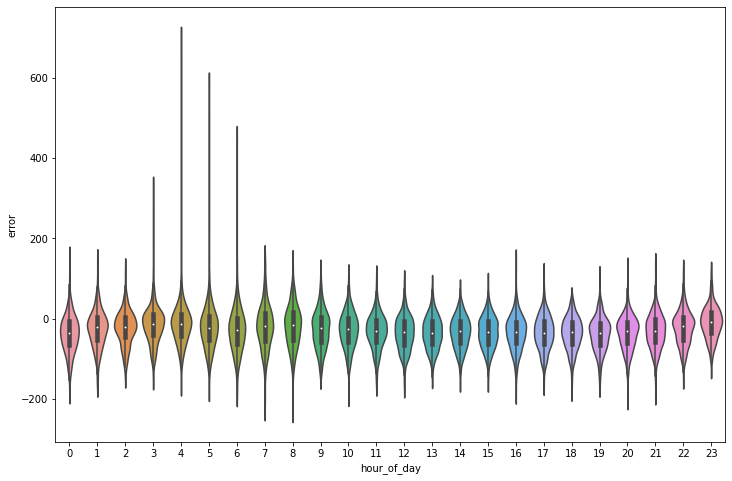

In [16]:
test_orig = load_intermediate(Path(module_path)/'data/processed/test.feather')
test_orig['error'] = pd.Series(predicted - actual).values
test_orig

import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(data=test_orig, x='hour_of_day', y='error', ax=ax)

At least we have to seek for better prediction during hours 3-6.
Experimentation showed (not displayed here) that sin-encoding of hour_of_day does not really affect this outcome.

One possible explanation might be that the DH storages are loaded during the night hours, when consumption is low and electricity prices are usually also lower. This needs to be investigated.

Possible features to add to the dataset:
- spot electricity price
- DH generation lag, cumulative generation from previous ~1-6 hours
- ambient temperature lead, average ambient temperature gradient for the next ~1-6 hours

<AxesSubplot:xlabel='month', ylabel='error'>

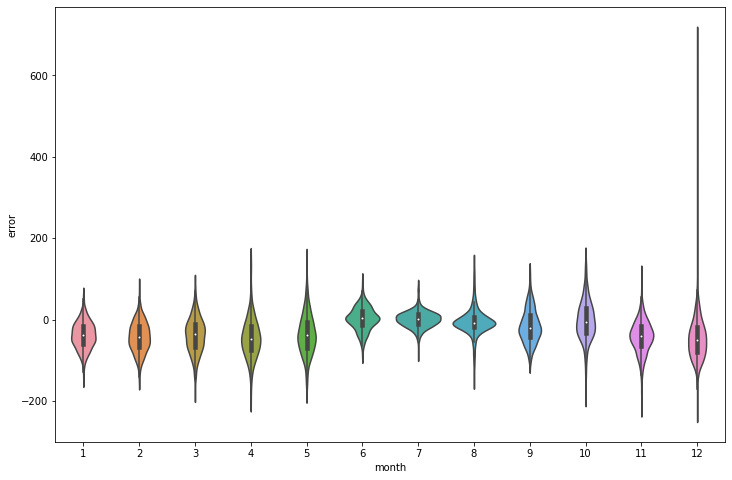

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
test_orig['month'] = test_orig.index.month
sns.violinplot(data=test_orig, x='month', y='error', ax=ax)

The outlier in 2019-12 is clearly visible over there. In general, there is more error during the colder season. The DH consumption is also lower in the summer, so that is not a big surprise.

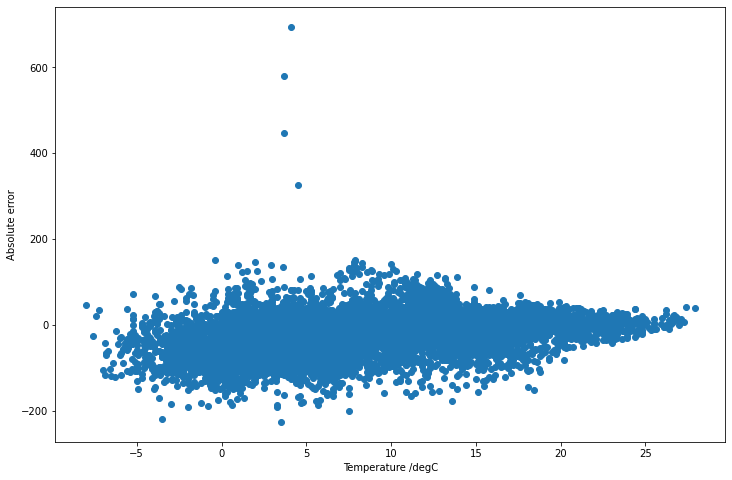

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x=test_orig["Ilman lämpötila (degC)"], y=test_orig['error'])
ax.set_xlabel("Temperature /degC")
ax.set_ylabel("Absolute error")
plt.show()

Not much to be seen over here

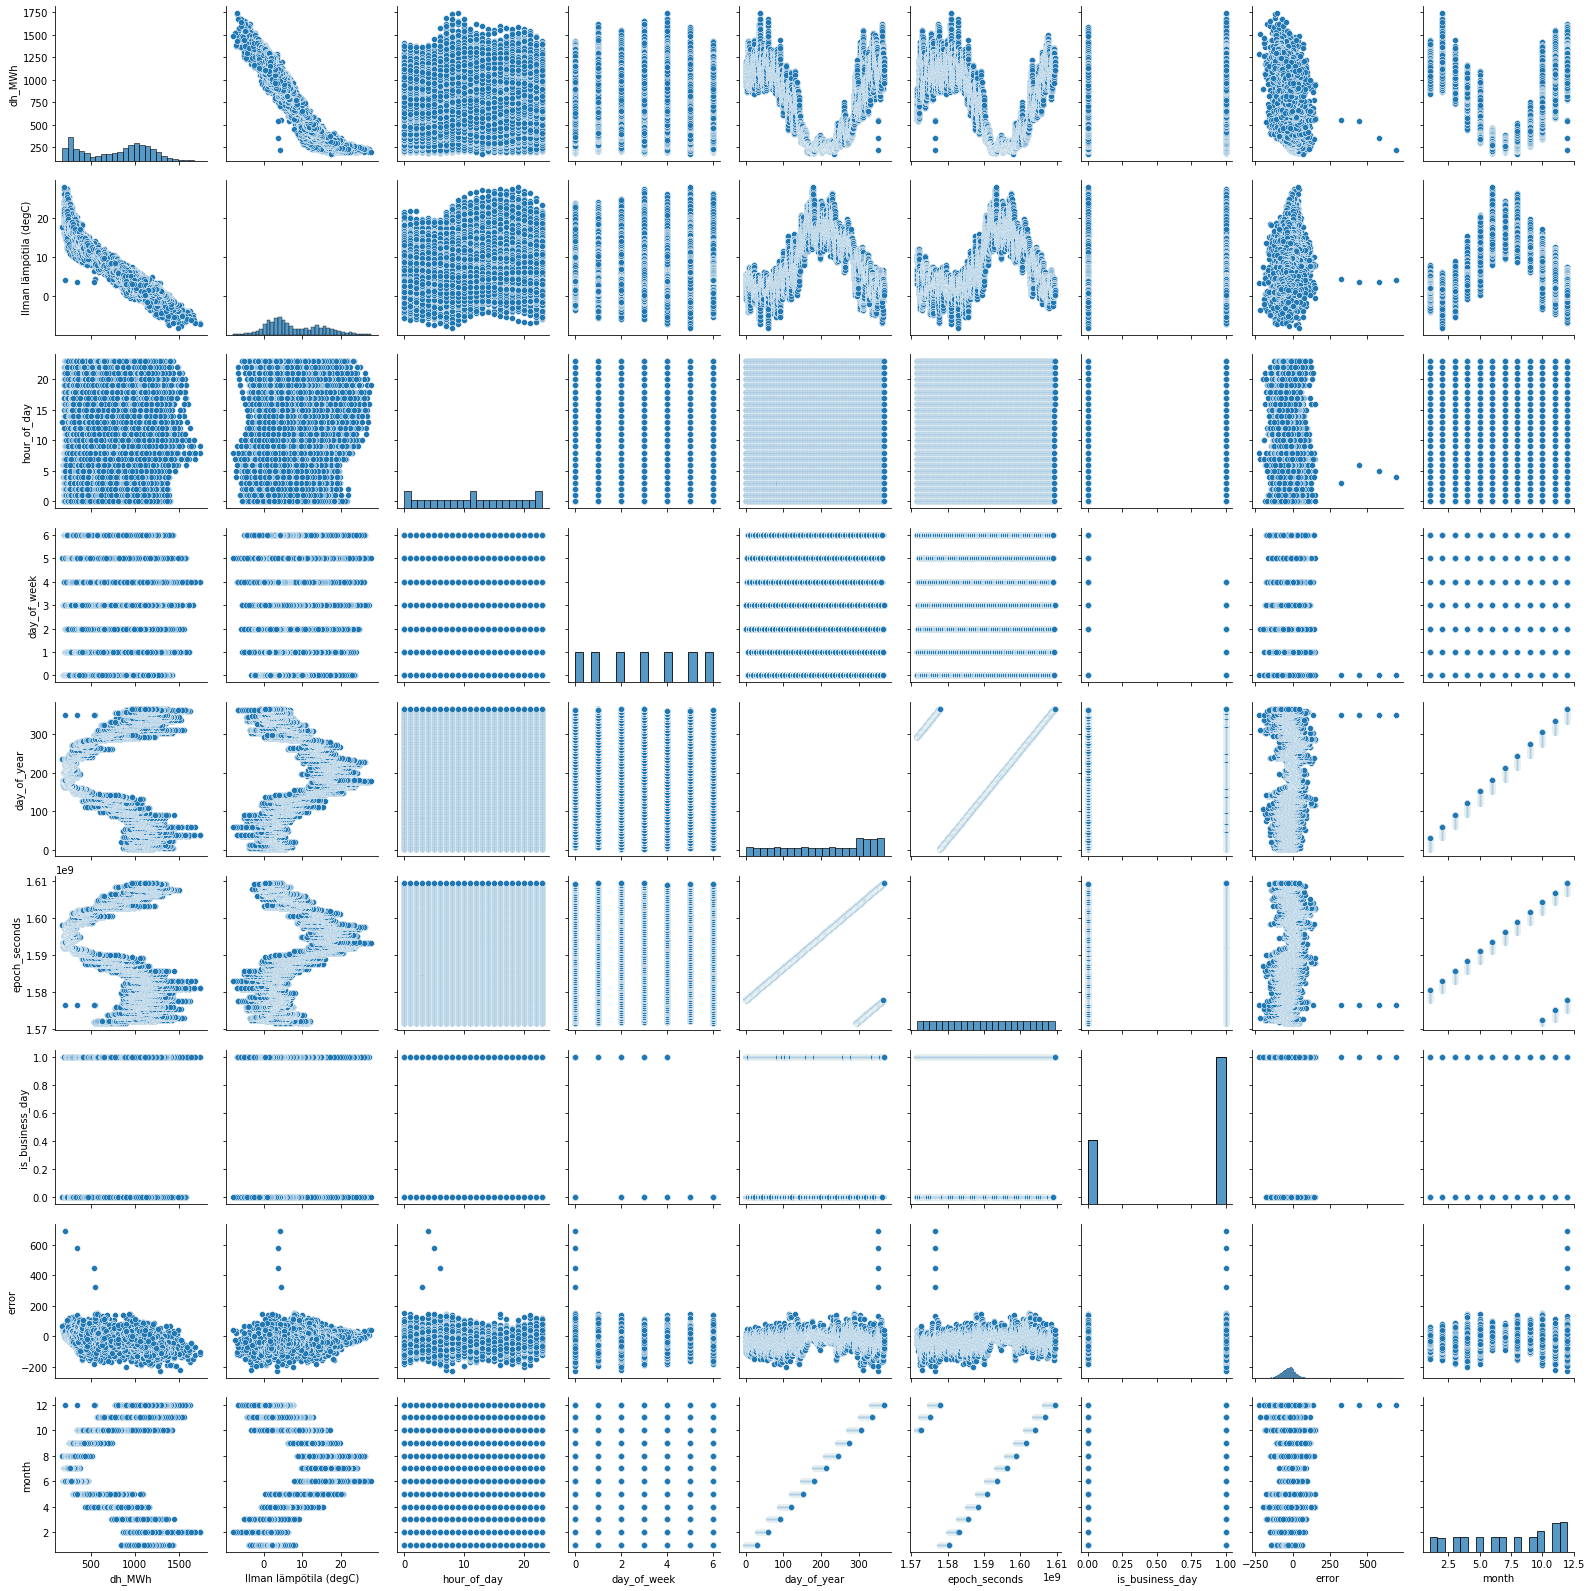

In [19]:
sns.pairplot(test_orig)

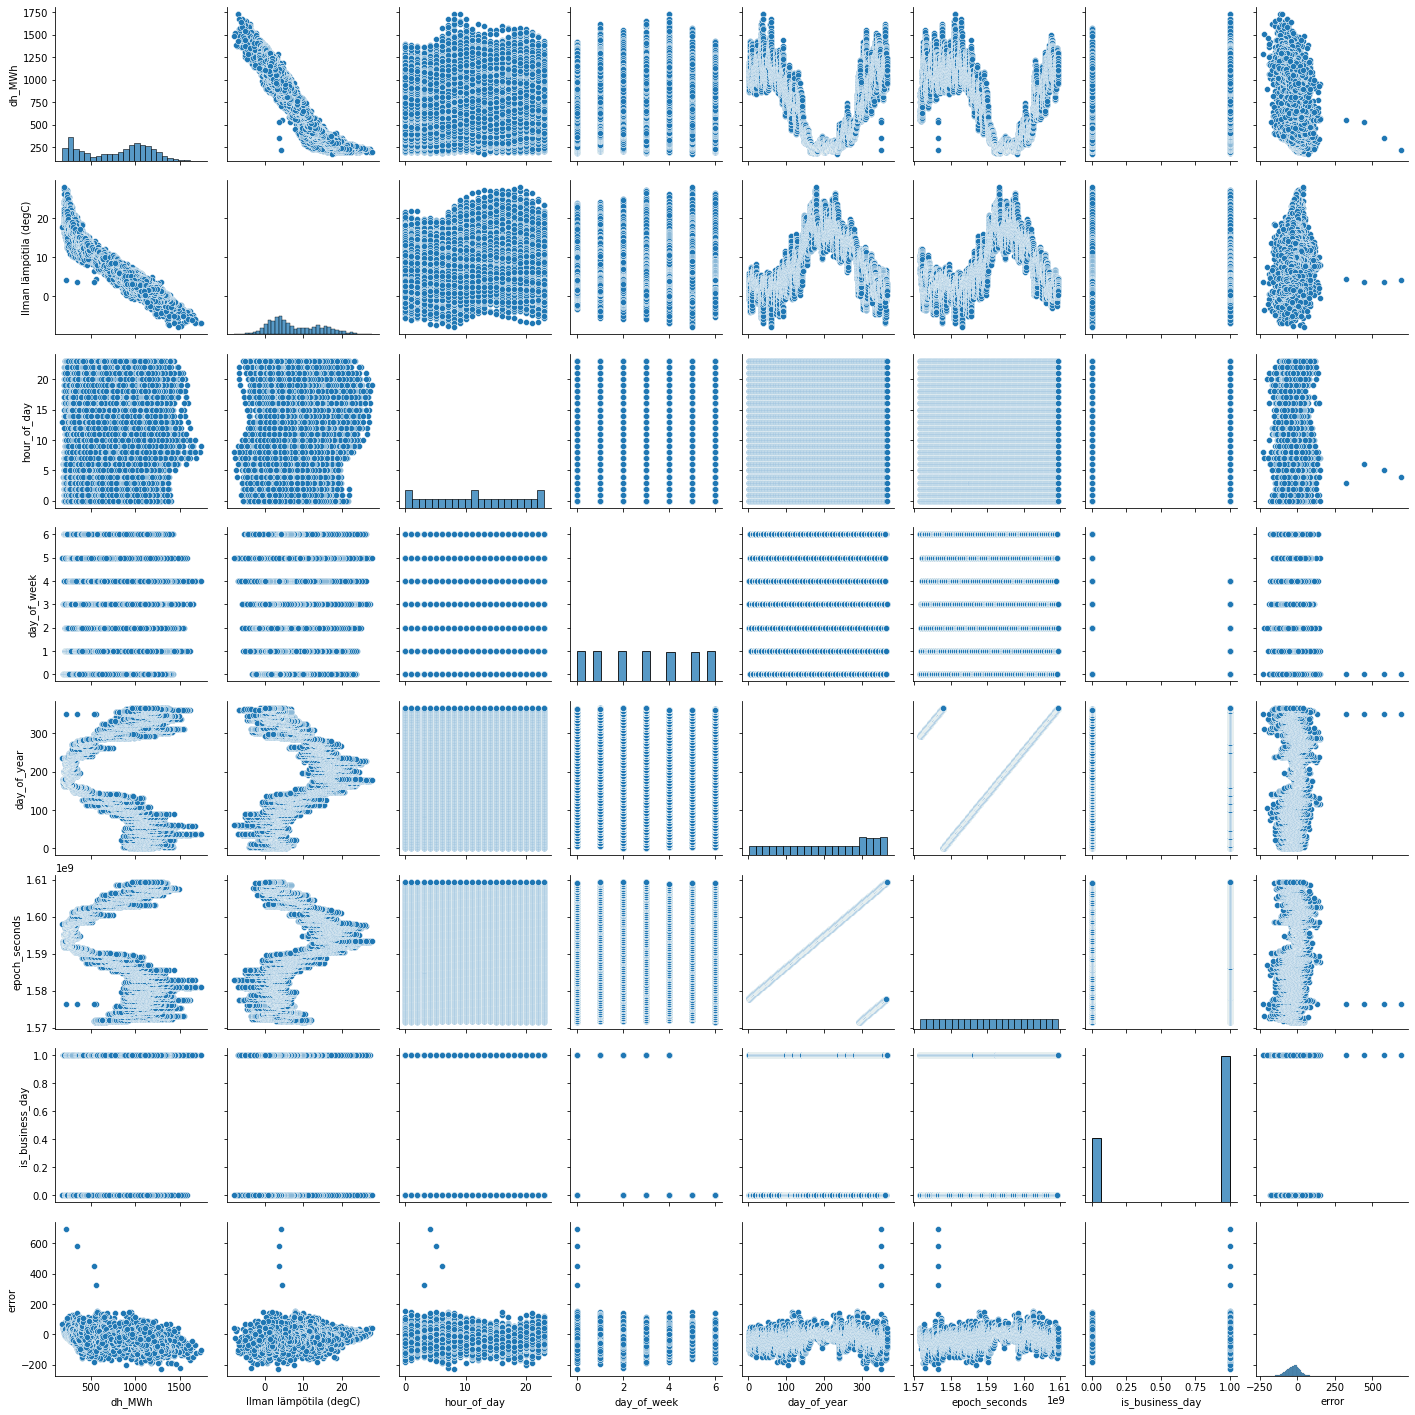

In [20]:
df_test['error'] = test_orig['error']
sns.pairplot(df_test)

All in all, it seems that a mean absolute percentage error of 5.3 % and mean absolute error of 34.4 MW

In [21]:
calculate_metrics(actual, predicted)

{'mean_absolute_error': 41.435479951569576,
 'mean_absolute_percentage_error': 0.060052684346592264,
 'root_mean_squared_error': 53.59658273460104}

In [22]:
greatest_error_indices = np.argsort(np.abs(df_test['error']))[::-1]
greatest_error_indices

date_time
2020-12-31 23:00:00+02:00     1358
2020-12-31 22:00:00+02:00     1359
2020-12-31 21:00:00+02:00     1360
2020-12-31 20:00:00+02:00     1357
2020-12-31 19:00:00+02:00     1362
                             ...  
2019-10-20 19:00:00+03:00     7330
2019-10-20 18:00:00+03:00     6294
2019-10-20 17:00:00+03:00     7890
2019-10-20 16:00:00+03:00    10303
2019-10-20 15:00:00+03:00     9796
Name: error, Length: 10522, dtype: int64

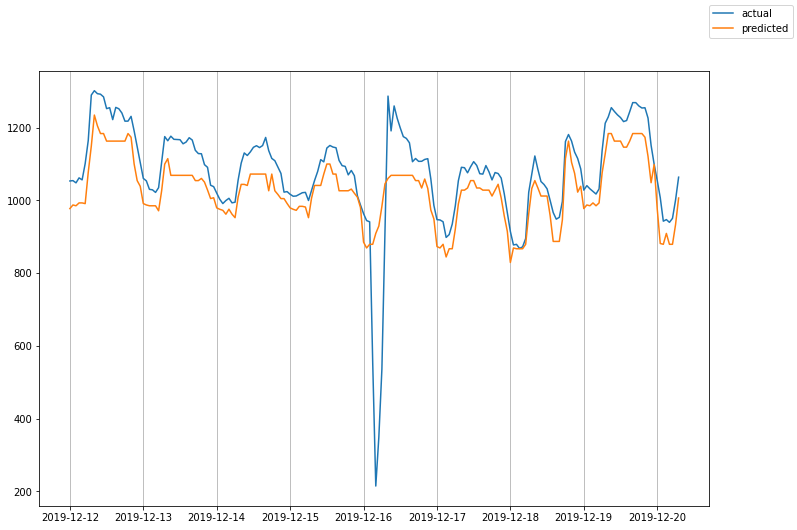

In [23]:
def plot_error_location(order, error_indices, delta=100):
    i = error_indices[order]
    idx = slice(i-delta,i+delta)

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(df_test.index[idx], actual[idx], label='actual')
    ax.plot(df_test.index[idx], predicted[idx], label='predicted')
    ax.xaxis.grid()
    fig.legend()
    return fig

fig = plot_error_location(0, greatest_error_indices)
plt.show()

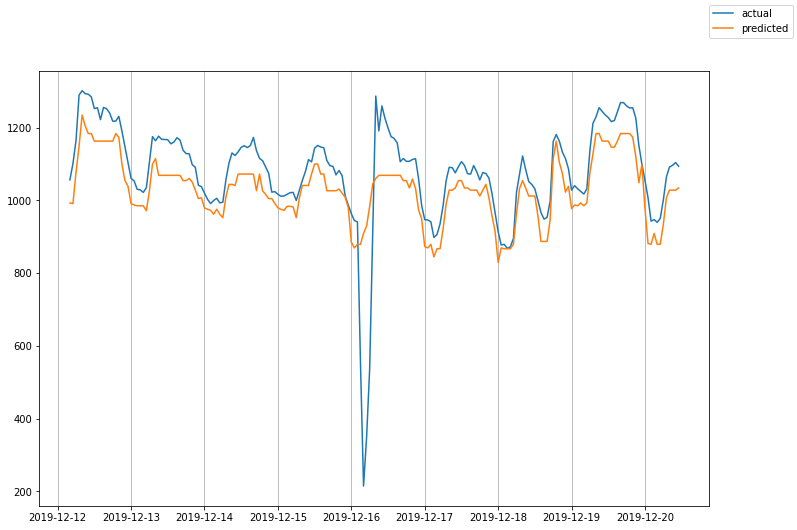

In [24]:
fig = plot_error_location(4, greatest_error_indices)
plt.show()